<a href="https://colab.research.google.com/github/felixlys/OptionBarrier-Option/blob/main/MonteCarloSimulationPricingExoticOption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementasi Metode Monte Carlo untuk Penetapan Harga Opsi Vanilla dan Opsi Barrier

Adapun model matematika pergerakan harga saham adalah sebagai berikut :

\begin{equation}
dS(t)=\mu\,dt+\sigma\,dW(t),
\end{equation}
dengan $\mu$ merupakan koefisien drift dan $\sigma$ merupakan koefisien volatilitas yang masing-masing diestimasikan oleh
\begin{equation}
\begin{aligned}
\sigma &=\frac{\tilde{\sigma}}{\sqrt{\Delta t}}\\
\mu&=\frac{1}{\Delta t}\left(\tilde{\mu}+\frac{1}{2}\tilde{\sigma^2}\right)
\end{aligned}
\end{equation}
dengan,
\begin{equation}
\begin{aligned}
\tilde{\mu}&=\frac{1}{n}\sum^{n}_{i=1} r_{i}\\
\tilde{\sigma^2}&=\frac{1}{n}\sum^{n}_{i=1} (r_{i}-\mu)^{2}\\
r_{i}&=\ln\left(\frac{S_{i+1}}{S_{i}}\right).
\end{aligned}
\end{equation}
untuk $i=1,2,3,\cdots,n$ merupakan return ke-$i$. Berikut merupakan langkah langkah untuk menestimasi parameter dari $\mu$ dan $\sigma$
1. Mengambil data harga penutupan dari 3 buah saham yakni BBRI.JK, BBCA.JK dan BBNI.JK

In [ ]:
import numpy as np
import yfinance as yf
lists=['BBRI.JK','BBCA.JK','BBNI.JK']
data = yf.download(lists,'2023-1-1','2024-1-1')['Adj Close']

[*********************100%%**********************]  3 of 3 completed


Berikut merupakan data harga penutupan dari 3 buah saham,

In [ ]:
print(data)

Ticker          BBCA.JK      BBNI.JK      BBRI.JK
Date                                             
2023-01-02  8154.729004  4220.121094  4349.535156
2023-01-03  8154.729004  4242.994629  4331.672852
2023-01-04  7963.975098  4197.248047  4260.222656
2023-01-05  7868.598145  4117.191406  4144.116211
2023-01-06  7916.286621  4071.444580  4126.253418
...                 ...          ...          ...
2023-12-21  9114.956055  4915.113770  5291.497070
2023-12-22  9114.956055  5010.552734  5386.412109
2023-12-27  9163.830078  5034.412598  5338.954590
2023-12-28  9188.267578  5105.991699  5433.869141
2023-12-29  9188.267578  5129.851562  5433.869141

[239 rows x 3 columns]


2. Dapatkan data return $r_{i}$ menghitung ln return

In [ ]:
#Menjadikan data harga saham menjadi array
BBCAP=np.array(data['BBCA.JK'])
BBNIP=np.array(data['BBNI.JK'])
BBRIP=np.array(data['BBRI.JK'])
#Susun suatu fungsi untuk mendapatkan return dari masing masing asset
def LnRet(harga):
    ret = np.zeros(len(harga) - 1)
    for i in range(1, len(harga)):
        ret[i-1] = np.log(harga[i] / harga[i-1])
    return ret
RetBBCAP=LnRet(BBCAP)
RetBBNIP=LnRet(BBNIP)
RetBBRIP=LnRet(BBRIP)

3. Dapatkan nilai dari $\mu$ dan $\sigma$ yakni koefisien drift dan volatilitas

In [ ]:
mu1=np.mean(RetBBCAP)
mu2=np.mean(RetBBNIP)
mu3=np.mean(RetBBRIP)
sig1=np.std(RetBBCAP)
sig2=np.std(RetBBNIP)
sig3=np.std(RetBBRIP)

Perhatikan bahwa harga saham yang akan disimulasikan adalah harga saham harian selama satu tahun, karena cashflow nya merupakan cashflow dalam satu tahun maka nilai $\Delta t=1/239$ hal ini mengingat dalan 1 thn ada 239 hari trading (minggu tutup)

In [ ]:
Dt=1/len(RetBBRIP)
vol1=sig1/np.sqrt(Dt)
vol2=sig2/np.sqrt(Dt)
vol3=sig3/np.sqrt(Dt)
drift1=(1/Dt)*(mu1+0.5*sig1**2)
drift2=(1/Dt)*(mu2+0.5*sig2**2)
drift3=(1/Dt)*(mu3+0.5*sig3**2)
print(drift1,drift2,drift3)

0.13410802154564855 0.21458769399490918 0.24319046263714036


Setelah didapatkan nilai parameter $\sigma$ dan $\mu$. Selanjutnya, dilakukan simulasi pergerakan harga saham selama 239 hari.

\par Berikut merupakan solusi It\^o dari Model Matematika
\begin{equation}
S(t)=S(0)\,\exp\left(\left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma\,W(t)\right).
\end{equation}
untuk setiap $t\in[0,T]$. Selanjutnya, perhatikan bahwa solusi untuk setiap $t\in [t,t+\Delta t]$ dan $\Delta W\approx Z\sqrt{\Delta t}$ maka solusinya menjadi ⁉
\begin{equation}
S(t+\Delta t)=S(t)\,\exp\left(\left(\mu-\frac{1}{2} \sigma^2\right)\Delta t+\sigma\,\Delta W \right)
\end{equation}
dengan memisalkan $S(t+\Delta t)=S_{i+1}$ dan $S(t)=S_{i}$ maka didapat
\begin{equation}
S_{i+1}=S_{i}\,\exp\left(\left(\mu-\frac{1}{2} \sigma^2\right)\Delta t+\sigma\,Z_{i}\sqrt{\Delta t} \right)
\end{equation}
dengan $Z\sim N(0,1)$.


In [ ]:
#Harga Saham 100 sample path
timesteps=len(BBCAP)
Sim=100
Z1=np.random.normal(size=(Sim,timesteps))
Z2=np.random.normal(size=(Sim,timesteps))
Z3=np.random.normal(size=(Sim,timesteps))
X1=np.zeros([Sim,timesteps])
X2=np.zeros([Sim,timesteps])
X3=np.zeros([Sim,timesteps])
Dt=1/timesteps
for i in range(Sim):
  for j in range(timesteps-1):
    X1[i,j+1]=(drift1-0.5*vol1**2)*(Dt)+vol1*np.sqrt(Dt)*Z1[i,j]
    X2[i,j+1]=(drift2-0.5*vol2**2)*(Dt)+vol2*np.sqrt(Dt)*Z2[i,j]
    X3[i,j+1]=(drift3-0.5*vol3**2)*(Dt)+vol3*np.sqrt(Dt)*Z3[i,j]
  S1=np.zeros([Sim,timesteps])
  S2=np.zeros([Sim,timesteps])
  S3=np.zeros([Sim,timesteps])
  S1[:,0]=BBCAP[0]
  S2[:,0]=BBNIP[0]
  S3[:,0]=BBRIP[0]
  for i in range(Sim):
    for j in range(timesteps-1):
      S1[i,j+1]=S1[i,j]*np.exp(X1[i,j+1])
      S2[i,j+1]=S2[i,j]*np.exp(X2[i,j+1])
      S3[i,j+1]=S3[i,j]*np.exp(X3[i,j+1])

Berikut merupakan plot rata-rata dari sample path dr simulasi harga saham dengan model Matematika:

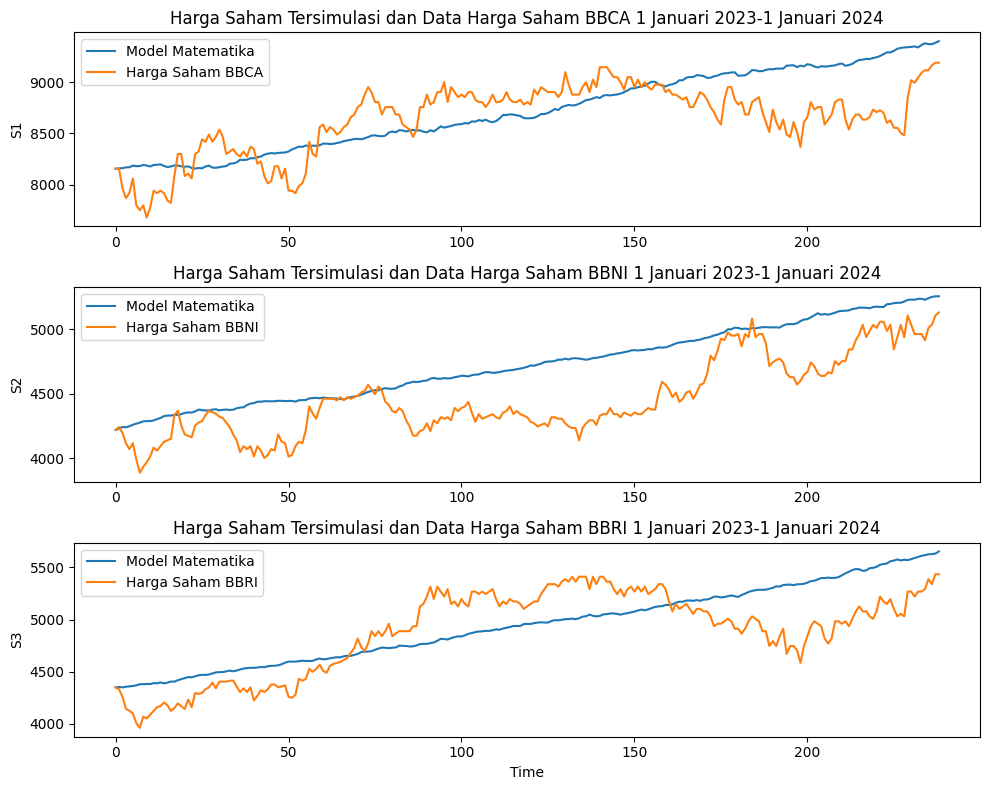

In [ ]:
t=np.arange(len(BBCAP))
S1av=np.average(S1,axis=0)
S2av=np.average(S2,axis=0)
S3av=np.average(S3,axis=0)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Plot S1av di subplot pertama
axs[0].plot(t, S1av,label='Model Matematika')
axs[0].plot(t, BBCAP,label='Harga Saham BBCA')  # Plot BBCAP di subplot yang sama
axs[0].set_title('Harga Saham Tersimulasi dan Data Harga Saham BBCA 1 Januari 2023-1 Januari 2024')
axs[0].set_ylabel('S1')
axs[0].legend()
# Plot S2av di subplot kedua
axs[1].plot(t, S2av,label='Model Matematika')
axs[1].plot(t, BBNIP,label='Harga Saham BBNI')  # Plot BBCAP di subplot yang sama
axs[1].set_title('Harga Saham Tersimulasi dan Data Harga Saham BBNI 1 Januari 2023-1 Januari 2024')
axs[1].set_ylabel('S2')
axs[1].legend()
# Plot S3av di subplot ketiga
axs[2].plot(t, S3av,label='Model Matematika')
axs[2].plot(t, BBRIP,label='Harga Saham BBRI')  # Plot BBCAP di subplot yang sama
axs[2].set_title('Harga Saham Tersimulasi dan Data Harga Saham BBRI 1 Januari 2023-1 Januari 2024')
axs[2].set_ylabel('S3')
axs[2].set_xlabel('Time')
axs[2].legend()
# Menampilkan plot
plt.tight_layout()

plt.show()

Setelah didapatkan harga Saham, dilakukan valuasi harga opsi dengan formula sebagai berikut ⁉
\begin{equation}
V_{j}=e^{-r\,T}\,\max(S(T)-K,0)
\end{equation}
untuk simulasi ke-$j=0,1,2,3,\cdots,1000$, $r=6.25\%$ merupakan suku bunga Bank Indonesia, $S(T)$ merupakan harga saham pada waktu akhir, dan $T$ merupakan waktu akhir. \\
Adapun harga opsi yang diinginkan adalah
  \begin{equation}
  \bar{V}=\sum^{100}_{j=1} V_{j}.
  \end{equation}
Hal ini mengingat nilai ekspektasi dari rata-rata sample adalah rata-rata populasi.


In [ ]:
V1=np.zeros(Sim)
V2=np.zeros(Sim)
V3=np.zeros(Sim)
ST1=S1[:,-1]
ST2=S2[:,-1]
ST3=S3[:,-1]
K=7000
for i in range(Sim):
  V1[i]=np.exp(-6.25/100)*np.max(ST1-K,0)
  V2[i]=np.exp(-6.25/100)*np.max(ST2-K,0)
  V3[i]=np.exp(-6.25/100)*np.max(ST3-K,0)
Harga1=np.mean(V1)
Harga2=np.mean(V2)
Harga3=np.mean(V3)
print('Harga Opsi BBCA=',Harga1)
print('Harga Opsi BBNI=',Harga2)
print('Harga Opsi BBRI=',Harga3)

Harga Opsi BBCA= 6307.573400200497
Harga Opsi BBNI= 654.5487899974867
Harga Opsi BBRI= 1185.759029899302


Berikut merupakan function untuk penetapan harga opsi Vanilla :

In [ ]:
#Vanilla Options
#By : Felix Lyanto Setiawan
import numpy as np
def VanillaMonteCarlo(r,std,Sim,timesteps,S0,K):
  Z=np.random.normal(size=(Sim,timesteps))
  X=np.zeros([Sim,timesteps])
  dt=1/timesteps
  for i in range(Sim):
    for j in range(timesteps-1):
      X[i,j+1]=((np.exp(r/timesteps)-1)-0.5*std**2)*(dt)+std*np.sqrt(dt)*Z[i,j]
  S=np.zeros([Sim,timesteps])
  S[:,0]=S0
  for i in range(Sim):
    for j in range(timesteps-1):
      S[i,j+1]=S[i,j]*np.exp(X[i,j+1])
  #Valuation
  ST=S[:,-1]
  V=np.zeros(Sim)
  for i in range(Sim):
    V[i]=np.exp(-r)*max(ST[i]-K,0)
  Harga=np.mean(V)
  return V,Harga
r = 0.08
std = 0.35
Sim = 1000
timesteps = 365
S0 = 100
B = 75
K = 70
V,Price = VanillaMonteCarlo(r, std, Sim, timesteps, S0, K)

print(Price)

29.959943714742924


Selanjutnya, dilakukan penetapan harga opsi Barrier Up and In dengan formula sebagai berikut ⁉

\begin{equation}
V_{j}=e^{-rT}\,I\left( S(T)-K,0\right)\\
I\left( S(T)-K,0\right)=\begin{cases}
1, S_{j}(i)\geq B\\
0, S_{j}(i)< B\\
\end{cases}
\end{equation}
untuk $i=0,1,2,3,\cdots,239$.

In [ ]:
#Barrier Elemination
V1=np.zeros(Sim)
V2=np.zeros(Sim)
V3=np.zeros(Sim)
ST1=S1[:,-1]
ST2=S2[:,-1]
ST3=S3[:,-1]
K=7000
B=9250
for i in range(Sim):
    Bawah_bar = False
    for j in range(len(BBCAP)):
      #Tes apakah harga saham mencapai barrier atau tidak
        if S1[i, j] >= B:
            Bawah_bar = True
            break
    # Jika mencapai barrier, hitung nilai opsi
    if Bawah_bar:
        V1[i] = np.exp(-6.25/100) * max(ST1[i] - K, 0)
    else:
        V1[i] = 0  # Jika tidak mencapai barrier, nilai opsi adalah 0
HargaBar1 = np.mean(V1)
print("Harga Opsi Barrier Up and In BBCA =", HargaBar1)

Harga Opsi Barrier Up and In BBCA = 1966.7732683171719


Sedangkan Up and Out dengan formula sebagai berikut
\begin{equation}
V_{j}=e^{-rT}\,I\left( S(T)-K,0\right)\\
I\left( S(T)-K,0\right)=\begin{cases}
0, S_{j}(i)\geq B\\
1, S_{j}(i)< B\\
\end{cases}
\end{equation}
untuk $i=0,1,2,3,\cdots,239$.

In [ ]:
#Barrier Elemination
V1out=np.zeros(Sim)
V2=np.zeros(Sim)
V3=np.zeros(Sim)
ST1=S1[:,-1]
ST2=S2[:,-1]
ST3=S3[:,-1]
K=7000
B=9250
for i in range(Sim):
    Bawah_bar = False
    for j in range(len(BBCAP)):
      #Tes apakah harga saham mencapai barrier atau tidak
        if S1[i, j] >= B:
            Bawah_bar = True
            break
    # Jika mencapai barrier, opsi bernilai 0
    if Bawah_bar:
        V1out[i]=0
    else:
        V1out[i] = np.exp(-6.25/100) * max(ST1[i] - K, 0)  # Jika tidak mencapai barrier, hitung nilai opsi
HargaBar1out = np.mean(V1out)
print("Harga Opsi Barrier Up and Out BBCA =", HargaBar1out)

Harga Opsi Barrier Up and Out BBCA = 301.56214687222115


Berdasarkan dua perhitungan nilai opsi Up and In dan Up and Out, tampak bahwa hasil yg didapat sesuai dengan konsep opsi. Dimana saat kondisi pasar naik harga opsi barrier up and in jauh lebih mahal daripada opsi barrier up and out. \\

Berikut merupakan fungsi untuk penetapan harga opsi barrier.

In [ ]:
#Down and Out Barrier Option with Monte Carlo Simulation
#By : Felix Lyanto Setiawan
Z=np.random.normal(size=(10,4)) #10 adalah jumlah simulasi 4 adalah jmlh timestep dr 0 i=0,1,2,3
r=np.exp(0.08/3)-1
std=0.35
dt=1/3
X=np.zeros([10,4])
for i in range (10):
  for j in range(3):
    X[i,j+1]=(r-0.5*std**2)*(1/3)+std*np.sqrt(dt)*Z[i,j]
S=np.zeros([10,4])
S[:,0]=100
for i in range(10):
  for j in range(3):
    S[i,j+1]=S[i,j]*np.exp(X[i,j+1])
#Barrier elemination
for i in range(10):
  if S[i,-1]<75:
    S[i,-1]=0
#Valuation
ST=S[:,-1]
K=70 #Strike Price
V=np.zeros(10)#Diganti dengan banyaknya simulasi ya bole
for i in range(10):
  V[i]=np.exp(-0.08)* max(ST[i]-K,0)# Klo put dibalik saja K dan ST nya
Price=np.mean(V)
print(Price)

28.980674521475173


In [ ]:
Z= np.random.normal(size=(10,4))
Val=np.zeros([10,4])
Val[:,0]=100
r=np.exp(0.08/3)-1
dt=1/3
std=0.35
for i in range(10):
  for j in range(3):
    Val[i,j+1]=Val[i,j]*np.exp((r-0.5*std**2)*dt+std*np.sqrt(dt)*Z[i,j])
print(Val)
ST=Val[:,-1]
print(ST)
Value=np.exp(-0.08)*np.max(ST-75,0)
print(Value)

[[100.         100.72497375 124.15052299  99.3178679 ]
 [100.          81.15041354  90.76178772 128.59335218]
 [100.         105.39459764 120.32535759 108.51788029]
 [100.          79.67037692  67.91908083  67.47112449]
 [100.          82.69940725 110.49245236 101.18350878]
 [100.          98.17008986 115.27533711  99.85926648]
 [100.          96.21243935 115.94037228 120.69551234]
 [100.          84.12602482  77.43247829  60.32323176]
 [100.         100.30400646 126.93543264 161.94177594]
 [100.          77.35629749  72.75784397  78.1186232 ]]
[ 99.3178679  128.59335218 108.51788029  67.47112449 101.18350878
  99.85926648 120.69551234  60.32323176 161.94177594  78.1186232 ]
80.25737455144626


In [ ]:
#Down and Out Barrier Option with Monte Carlo Simulation
#By : Felix Lyanto Setiawan
def DownandOutMonteCarlo(r,std,Sim,timesteps,S0,B,K):
  Z=np.random.normal(size=(Sim,timesteps))
  X=np.zeros([Sim,timesteps])
  dt=1/timesteps
  for i in range(Sim):
    for j in range(timesteps-1):
      X[i,j+1]=((np.exp(r/timesteps)-1)-0.5*std**2)*(dt)+std*np.sqrt(dt)*Z[i,j]
  S=np.zeros([Sim,timesteps])
  S[:,0]=S0
  for i in range(Sim):
    for j in range(timesteps-1):
      S[i,j+1]=S[i,j]*np.exp(X[i,j+1])
  #Barrier Elemination
  for i in range(Sim):
    if S[i,-1]<B:
      S[i,-1]=0
  #Valuation
  ST=S[:,-1]
  V=np.zeros(Sim)
  for i in range(Sim):
    V[i]=np.exp(-r)*max(ST[i]-K,0)
  Harga=np.mean(V)
  return V,Harga
r = 0.08
std = 0.35
Sim = 1000
timesteps = 365
S0 = 100
B = 75
K = 70
V,Price = DownandOutMonteCarlo(r, std, Sim, timesteps, S0, B, K)

print(Price)

31.323713004313174
